### Importing libraries and data

In [84]:
# !pip install lightgbm
# !pip install seaborn --upgrade
# !pip install shap

In [86]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

import pickle

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier, plot_importance as plot_importance_lgbm

import re
from scipy import stats
from tqdm import tqdm
import glob
import time
import random
import shap

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, f1_score, roc_curve, auc, roc_auc_score, precision_recall_curve

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from utils import clean_text, cap_values, categorize_value, calculate_risk_score, preprocess_data, evaluate_model, tune_model, \
 train_models, load_models, load_model_params

random.seed(42)

#### Feature sets for train data

In [5]:
with open(r'.\dumps\train_feature_sets.pkl', 'rb') as f:
    train_feature_sets = pickle.load(f)

train_feature_sets.keys()

dict_keys(['[X_tr_imb, y_tr_imb]', '[X_tr_smote, y_tr_smote]', '[X_tr_std, y_tr_std]', '[X_tr_smote_std, y_tr_smote]'])

#### Feature sets for test data

In [7]:
with open(r'.\data_for_model\test\test_data.pkl', 'rb') as f:
    X_test, y_test = pickle.load(f)

X_test.shape, y_test.shape

((138, 11), (138,))

In [8]:
X_test = preprocess_data(X_test)
X_test.head(2)

,Age,RestingBP,Cholesterol,MaxHR,Oldpeak,New_Risk_Score,Sex,FastingBS,ExerciseAngina,ChestPainType_asy,...,RestingECG_lvh,RestingECG_normal,RestingECG_st,ST_Slope_down,ST_Slope_flat,ST_Slope_up,New_Cholesterol_Bin_high,New_Cholesterol_Bin_low,New_Cholesterol_Bin_medium,New_Cholesterol_Bin_zero
0,51,125,188,145,0.0,2,1,0,0,0,...,0,1,0,0,0,1,0,1,0,0
1,70,130,322,109,2.4,8,1,0,0,1,...,1,0,0,0,1,0,1,0,0,0


In [9]:
# Feature columns

with open(r'.\dumps\num_FE_features.pkl', 'rb') as f:
    num_FE_features = pickle.load(f)

with open(r'.\dumps\numeric_columns.pkl', 'rb') as f:
    numeric_cols = pickle.load(f)

with open(r'.\dumps\mapping_features.pkl', 'rb') as f:
    mapping_features = pickle.load(f)

with open(r'.\dumps\one_hot_encoder_feature_names.pkl', 'rb') as f:
    one_hot_encoder_feature_names = pickle.load(f)

num_cols = numeric_cols + num_FE_features

In [10]:
with open(r'.\dumps\2_standardscaler.pkl', 'rb') as f:
    scaler = pickle.load(f)

num_scaled = pd.DataFrame(scaler.transform(X_test[num_cols]), columns=num_cols)
X_te_std = pd.concat([num_scaled, X_test[mapping_features], X_test[one_hot_encoder_feature_names]], axis=1)

In [11]:
with open(r'.\dumps\3_smote_standardscaler.pkl', 'rb') as f:
    scaler = pickle.load(f)

num_scaled = pd.DataFrame(scaler.transform(X_test[num_cols]), columns=num_cols)
X_te_smote_std = pd.concat([num_scaled, X_test[mapping_features], X_test[one_hot_encoder_feature_names]], axis=1)

In [12]:
test_feature_sets = {
    '[X_test, y_test]' : [X_test, y_test],
    '[X_te_std, y_test]' : [X_te_std, y_test],
    '[X_te_smote_std, y_test]' : [X_te_smote_std, y_test]  
}

with open(r'.\dumps\test_feature_sets.pkl', 'wb') as f:
    pickle.dump(test_feature_sets, f)

In [13]:
%%time
random.seed(42)

results = []
results += train_models('[X_tr_imb, y_tr_imb]', '[X_test, y_test]')
results += train_models('[X_tr_smote, y_tr_smote]', '[X_test, y_test]')

results += train_models('[X_tr_std, y_tr_std]', '[X_te_std, y_test]')
results += train_models('[X_tr_smote_std, y_tr_smote]', '[X_te_smote_std, y_test]')

100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  8.16it/s]

[LightGBM] [Info] Number of positive: 432, number of negative: 348
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000292 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 408
[LightGBM] [Info] Number of data points in the train set: 780, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.553846 -> initscore=0.216223
[LightGBM] [Info] Start training from score 0.216223
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[


 50%|██████████████████████████████████████████                                          | 3/6 [00:00<00:00, 25.22it/s]

[LightGBM] [Info] Number of positive: 432, number of negative: 432
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000379 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 438
[LightGBM] [Info] Number of data points in the train set: 864, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

 83%|██████████████████████████████████████████████████████████████████████              | 5/6 [00:00<00:00, 16.31it/s]

[LightGBM] [Info] Number of positive: 432, number of negative: 348
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000581 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 411
[LightGBM] [Info] Number of data points in the train set: 780, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.553846 -> initscore=0.216223
[LightGBM] [Info] Start training from score 0.216223
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.80it/s]


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


 83%|██████████████████████████████████████████████████████████████████████              | 5/6 [00:00<00:00, 16.64it/s]

[LightGBM] [Info] Number of positive: 432, number of negative: 432
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000655 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 441
[LightGBM] [Info] Number of data points in the train set: 864, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 10.59it/s]

CPU times: total: 5 s
Wall time: 2.47 s


In [14]:
results_df = pd.DataFrame(results)
results_df.sort_values(by=['test_f1'], ascending=[False])

,Model,train_data,test_data,train_f1,test_f1,train_accuracy,test_accuracy
20,SVC,"[X_tr_smote_std, y_tr_smote]","[X_te_smote_std, y_test]",0.9108,0.9203,0.9109,0.9203
10,Random Forest,"[X_tr_smote, y_tr_smote]","[X_test, y_test]",1.0000,0.9130,1.0000,0.9130
18,Logistic Regression,"[X_tr_smote_std, y_tr_smote]","[X_te_smote_std, y_test]",0.8796,0.9059,0.8796,0.9058
22,Random Forest,"[X_tr_smote_std, y_tr_smote]","[X_te_smote_std, y_test]",1.0000,0.9057,1.0000,0.9058
4,Random Forest,"[X_tr_imb, y_tr_imb]","[X_test, y_test]",1.0000,0.9057,1.0000,0.9058
16,Random Forest,"[X_tr_std, y_tr_std]","[X_te_std, y_test]",1.0000,0.9057,1.0000,0.9058
12,Logistic Regression,"[X_tr_std, y_tr_std]","[X_te_std, y_test]",0.8676,0.8986,0.8679,0.8986
11,LightGBM,"[X_tr_smote, y_tr_smote]","[X_test, y_test]",1.0000,0.8916,1.0000,0.8913
23,LightGBM,"[X_tr_smote_std, y_tr_smote]","[X_te_smote_std, y_test]",1.0000,0.8916,1.0000,0.8913
14,SVC,"[X_tr_std, y_tr_std]","[X_te_std, y_test]",0.9009,0.8910,0.9013,0.8913


**Observation:**

    1. SVC and Random Forest are top models to tune
    2. [X_tr_smote_std, y_tr_smote] is top data feature set

#### Tuning top models

In [17]:
%%time
random.seed(42)
results = []
results += train_models('[X_tr_std, y_tr_std]', '[X_te_std, y_test]', tune=True, models={'Random Forest': RandomForestClassifier()})

results += train_models('[X_tr_smote, y_tr_smote]', '[X_test, y_test]', tune=True, models={'Random Forest': RandomForestClassifier(),
                                                                                          'LightGBM': LGBMClassifier()})

results += train_models('[X_tr_smote_std, y_tr_smote]', '[X_te_smote_std, y_test]', tune=True, models={'Random Forest': RandomForestClassifier(),
                                                                                                       'SVC': SVC(),
                                                                                                      'Logistic Regression': LogisticRegression(),
                                                                                                      'LightGBM': LGBMClassifier()})

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

Fitting 5 folds for each of 10 candidates, totalling 50 fits


  0%|                                                                                            | 0/2 [00:00<?, ?it/s]

Fitting 5 folds for each of 10 candidates, totalling 50 fits


 50%|██████████████████████████████████████████                                          | 1/2 [00:01<00:01,  1.74s/it]

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[LightGBM] [Info] Number of positive: 432, number of negative: 432
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000651 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 438
[LightGBM] [Info] Number of data points in the train set: 864, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:48<00:00, 24.19s/it]


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

Fitting 5 folds for each of 10 candidates, totalling 50 fits


 25%|█████████████████████                                                               | 1/4 [00:05<00:15,  5.25s/it]

Fitting 5 folds for each of 10 candidates, totalling 50 fits


 50%|██████████████████████████████████████████                                          | 2/4 [00:05<00:04,  2.50s/it]

Fitting 5 folds for each of 10 candidates, totalling 50 fits


 75%|███████████████████████████████████████████████████████████████                     | 3/4 [00:06<00:01,  1.58s/it]

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[LightGBM] [Info] Number of positive: 432, number of negative: 432
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000736 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 441
[LightGBM] [Info] Number of data points in the train set: 864, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:43<00:00, 10.94s/it]

CPU times: total: 10.7 s
Wall time: 1min 38s


In [18]:
results_df = pd.DataFrame(results)
results_df.sort_values(by=['test_f1'], ascending=[False])

,Model,train_data,test_data,train_f1,test_f1,train_accuracy,test_accuracy
5,Logistic Regression,"[X_tr_smote_std, y_tr_smote]","[X_te_smote_std, y_test]",0.8796,0.9059,0.8796,0.9058
1,Random Forest,"[X_tr_smote, y_tr_smote]","[X_test, y_test]",0.9178,0.8987,0.9178,0.8986
3,Random Forest,"[X_tr_smote_std, y_tr_smote]","[X_te_smote_std, y_test]",0.9166,0.8986,0.9167,0.8986
0,Random Forest,"[X_tr_std, y_tr_std]","[X_te_std, y_test]",0.9087,0.8910,0.9090,0.8913
4,SVC,"[X_tr_smote_std, y_tr_smote]","[X_te_smote_std, y_test]",0.8796,0.8765,0.8796,0.8768
2,LightGBM,"[X_tr_smote, y_tr_smote]","[X_test, y_test]",0.8958,0.8698,0.8958,0.8696
6,LightGBM,"[X_tr_smote_std, y_tr_smote]","[X_te_smote_std, y_test]",0.8958,0.8698,0.8958,0.8696


#### Final model and feature set selected

In [20]:
models = load_models()
model_params = load_model_params()

In [21]:
model = models['Random Forest']
param_grid = model_params['Random Forest']

In [22]:
train_feature_sets.keys()

dict_keys(['[X_tr_imb, y_tr_imb]', '[X_tr_smote, y_tr_smote]', '[X_tr_std, y_tr_std]', '[X_tr_smote_std, y_tr_smote]'])

In [23]:
random.seed(42)
best_model = tune_model('grid', model, param_grid, train_feature_sets['[X_tr_smote_std, y_tr_smote]'][0], 
                        train_feature_sets['[X_tr_smote_std, y_tr_smote]'][1], scoring=['accuracy'], n_iter=10, cv=5, random_state=42)

# best_model = tune_model('grid', model, param_grid, train_feature_sets['[X_tr_smote, y_tr_smote]'][0], 
#                         train_feature_sets['[X_tr_smote, y_tr_smote]'][1], scoring=['accuracy'], n_iter=10, cv=5, random_state=42)

# best_model = tune_model('grid', model, param_grid, train_feature_sets['[X_tr_std, y_tr_std]'][0], 
#                         train_feature_sets['[X_tr_std, y_tr_std]'][1], scoring=['accuracy'], n_iter=10, cv=5, random_state=42)

Fitting 5 folds for each of 162 candidates, totalling 810 fits


In [24]:
with open(r'.\final_model\train_data.pkl', 'wb') as f:
    pickle.dump(train_feature_sets['[X_tr_smote_std, y_tr_smote]'], f)

with open(r'.\final_model\test_data.pkl', 'wb') as f:
    pickle.dump([X_te_smote_std, y_test], f)

with open(r'.\final_model\final_model.pkl', 'wb') as f:
    pickle.dump(best_model, f)

best_model.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 10,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 4,
 'min_samples_split': 10,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 200,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

train_f1: 0.9167 test_f1: 0.9058 

Classification Report on train data:
               precision    recall  f1-score   support

           0       0.93      0.90      0.92       432
           1       0.90      0.94      0.92       432

    accuracy                           0.92       864
   macro avg       0.92      0.92      0.92       864
weighted avg       0.92      0.92      0.92       864
 

Classification Report on test data:
               precision    recall  f1-score   support

           0       0.89      0.90      0.90        62
           1       0.92      0.91      0.91        76

    accuracy                           0.91       138
   macro avg       0.90      0.91      0.90       138
weighted avg       0.91      0.91      0.91       138





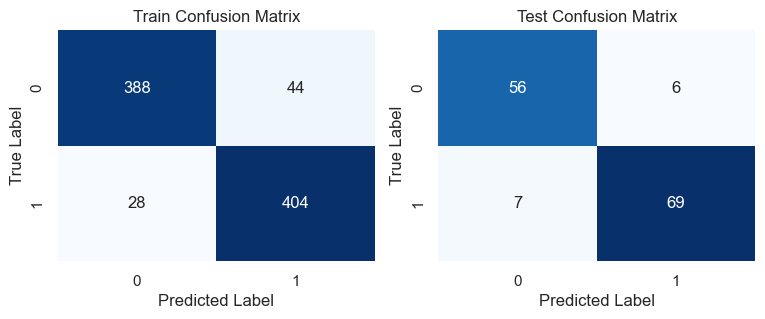

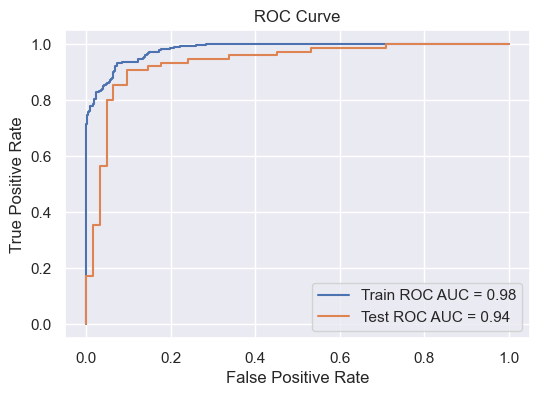

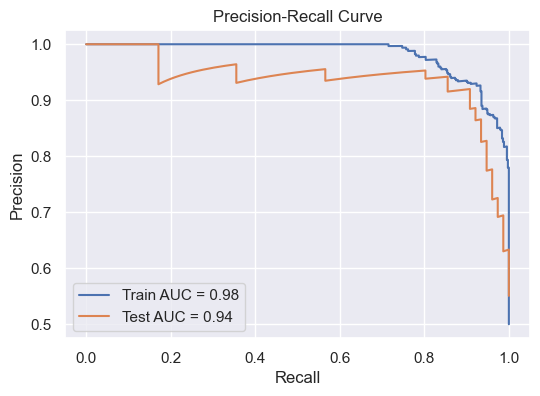

In [50]:
evaluate_model(best_model, train_feature_sets['[X_tr_smote_std, y_tr_smote]'][0],
               train_feature_sets['[X_tr_smote_std, y_tr_smote]'][1], 
               X_te_smote_std, y_test)

#### Feature Importance

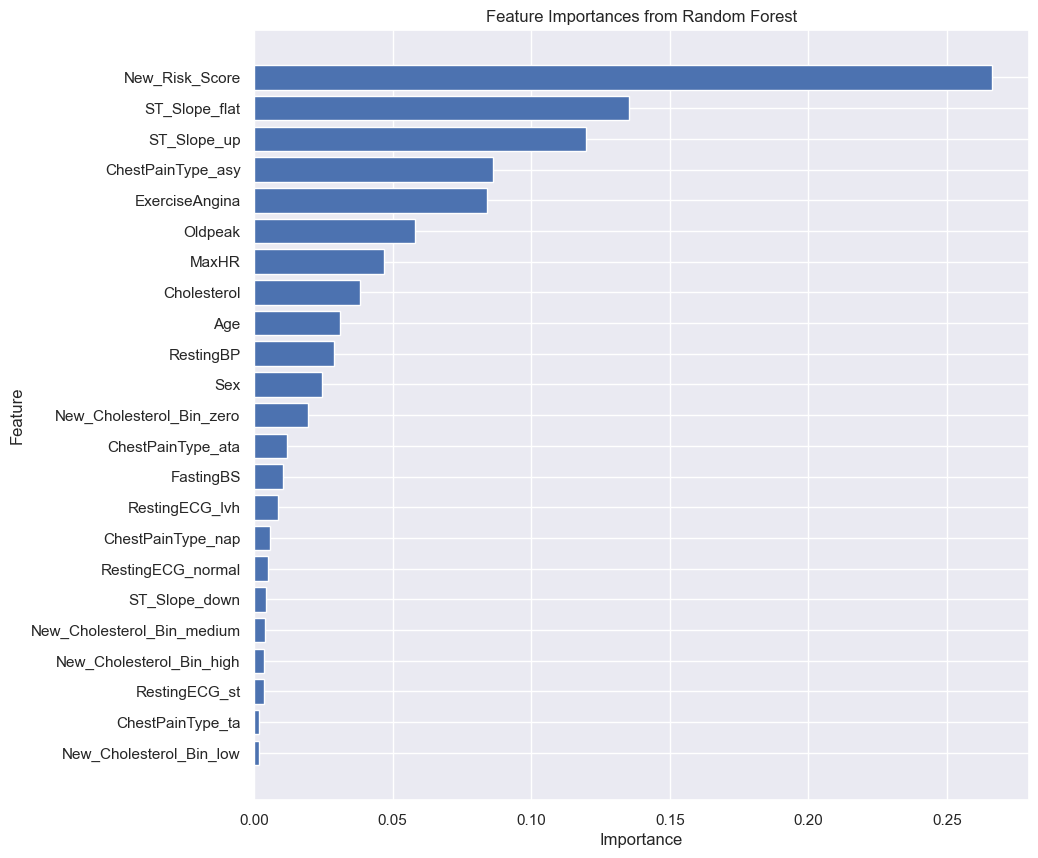

In [66]:
# Extract coefficients and feature names
importances = best_model.feature_importances_

# Create a DataFrame for better visualization
feature_importance_df = pd.DataFrame({
    'Feature': X_te_smote_std.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# print(feature_importance_df)

# Plot feature importances
plt.figure(figsize=(10, 10))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances from Random Forest')
plt.gca().invert_yaxis()
plt.show()

Below are top 6 features. We can see that FE New_Risk score has major contribution

In [74]:
feature_importance_df[:6]

,Feature,Importance
5,New_Risk_Score,0.266171
17,ST_Slope_flat,0.135354
18,ST_Slope_up,0.119773
9,ChestPainType_asy,0.086128
8,ExerciseAngina,0.084037
4,Oldpeak,0.058080
